# Part 1 - Load Data

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.util import MLUtils
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import types
from pyspark.sql.functions import *


rdd1 = sc.textFile("default of credit card clients1.csv")
rdd1.take(4)

[',X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y',
 'ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month',
 '1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1',
 '2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1']

# Part 2 - Data Transformation

In [2]:
#Remove First Header Record
Header = rdd1.filter(lambda l: "X1" in l)
Header.collect()
rddNoHeader = rdd1.subtract(Header)
rddNoHeader.take(2)

['ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month',
 '1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1']

In [3]:
#Remove Second Header Record
Header2 = rddNoHeader.filter(lambda l: "ID" in l)
Header2.collect()
rddNoHeader1 = rddNoHeader.subtract(Header2)
rddNoHeader1.take(2)

['2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1',
 '5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0']

In [4]:
#Split the comma separated data
rdd = rddNoHeader1.map(lambda line: line.split(","))

In [5]:
#Convert rdd to dataframe and give column names
df = rdd.map(lambda line: Row(ID=line[0],
LIMIT_BAL=line[1],
SEX=line[2],
EDUCATION=line[3],
MARRIAGE=line[4],
AGE=line[5],
PAY_0=line[6],
PAY_2=line[7],
PAY_3=line[8],
PAY_4=line[9],
PAY_5=line[10],
PAY_6=line[11],
BILL_AMT1=line[12],
BILL_AMT2=line[13],
BILL_AMT3=line[14],
BILL_AMT4=line[15],
BILL_AMT5=line[16],
BILL_AMT6=line[17],
PAY_AMT1=line[18],
PAY_AMT2=line[19],
PAY_AMT3=line[20],
PAY_AMT4=line[21],
PAY_AMT5=line[22],
PAY_AMT6=line[23],
default_payment_next_month=line[24])).toDF()

In [6]:
#keep 23 attributes for float conversion
df_float = df.drop('default_payment_next_month')
#keep class variable for integer conversion
df_int = df.select('default_payment_next_month')

#Convert all features to float
df_1 = df_float.select(*(col(c).cast("float").alias(c) for c in df_float.columns))

#Feature selection, drop the ID column as it is not useful
df_1 = df_1.drop('ID')

#Convert the target variable to integer
df_2 = df_int.select(*(col(c).cast("integer").alias(c) for c in df_int.columns))

features = df_1.rdd.map(lambda line: line[0:])

In [7]:
lab = df_2.rdd.map(lambda line: line[0])

In [8]:
#Data Transformation - Normalization
#Normalize features between 0 and 1
new_df = lab.zip(features.map(lambda x:Vectors.dense(x))).toDF(schema=['id','features'])

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(new_df)
scaledData = scalerModel.transform(new_df)
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
scaledData.select("features", "scaledFeatures").show()

Features scaled to range: [0.000000, 1.000000]
+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[26.0,2682.0,1725...|[0.08620689655172...|
|[57.0,8617.0,5670...|[0.62068965517241...|
|[29.0,70887.0,670...|[0.13793103448275...|
|[26.0,15329.0,165...|[0.08620689655172...|
|[33.0,30518.0,296...|[0.20689655172413...|
|[33.0,218668.0,22...|[0.20689655172413...|
|[28.0,22848.0,236...|[0.12068965517241...|
|[39.0,70800.0,720...|[0.31034482758620...|
|[22.0,18565.0,172...|[0.01724137931034...|
|[44.0,8583.0,8303...|[0.39655172413793...|
|[24.0,5580.0,0.0,...|[0.05172413793103...|
|[35.0,304991.0,31...|[0.24137931034482...|
|[34.0,10674.0,120...|[0.22413793103448...|
|[32.0,86627.0,781...|[0.18965517241379...|
|[56.0,208775.0,18...|[0.60344827586206...|
|[37.0,105420.0,10...|[0.27586206896551...|
|[47.0,1234.0,396....|[0.44827586206896...|
|[46.0,21148.0,238...|[0.43103448275862...|
|[27.0,101640.0,10...|[0.1034

In [9]:
#Label the data
from pyspark.mllib.regression import LabeledPoint

#Keep only id and scaledfeatures
transformed_data = scaledData.select("id","scaledFeatures")
#Label id and scaledfeatures
LabeledData = transformed_data.rdd.map(lambda x: LabeledPoint(x[0],[x[1]]))
LabeledData.take(3)

[LabeledPoint(1.0, [0.08620689655172414,0.14889243432608523,0.06785750891138721,0.08781713374617661,0.1632199369622433,0.08407395104635079,0.26348474217820017,0.3333333333333333,0.1111111111111111,0.6666666666666666,0.1,0.4,0.2,0.2,0.2,0.4,0.0,0.0005937329116246374,0.0011160216061782955,0.001610305958132045,0.0,0.0037831069143845074,1.0]),
 LabeledPoint(0.0, [0.6206896551724138,0.1541442237837484,0.07160143037729617,0.10601953602623983,0.17986295976020783,0.09963262452838607,0.27568054826565186,0.3333333333333333,0.04040404040404041,0.3333333333333333,0.1,0.2,0.1,0.2,0.2,0.2,0.0022895030862501602,0.02177871693130332,0.011160216061782956,0.014492753623188406,0.0016153649575996005,0.0012843647974335403,0.0]),
 LabeledPoint(0.0, [0.13793103448275862,0.20924598107586026,0.1298623527580696,0.12124228526814956,0.21637060021514978,0.13704344549605604,0.3036386844513847,0.16666666666666666,0.24242424242424243,0.6666666666666666,0.2,0.2,0.2,0.2,0.2,0.2,0.0034342546293752406,0.001781198734873911

In [10]:
#Split in training and test set in 70-30 proportion
trainingData, testingData = LabeledData.randomSplit([.8,.2],seed=1234)

# Part 3 - Machine Learning Algorithms Comparison

In [11]:
#Supervised Learning - Decision Tree Algorithm
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.util import MLUtils

# Note the arguments passed to train the model i.e. to build decision tree
model1 = DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={}, impurity='gini', maxDepth=3, maxBins=64)

#Predict and Test error
predictions1 = model1.predict(testingData.map(lambda x: x.features))
labelsAndPredictions1 = testingData.map(lambda lp: lp.label).zip(predictions1)

# Count number of mismatches with test data provided
testErr1 = labelsAndPredictions1.filter(lambda w: w[0] != w[1]).count() / float(testingData.count())

print('Test Error = ' + str(testErr1))

Test Error = 0.17456317204301075


In [31]:
metrics = BinaryClassificationMetrics(labelsAndPredictions1)
print(metrics.unpersist())

None


In [27]:
#Supervised Learning - Random Forest Algorithm
from pyspark.mllib.tree import RandomForest

# Only difference is here. Note the arg 'numTree'. Normally more trees taken into consideration increases the accuracy of our prediction. But most of the time increase is so slight compared to significant increase in time taken to learn the model after a certain number of trees in the ensemble. 
model2 = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={}, numTrees=20, featureSubsetStrategy="auto", impurity='gini', maxDepth=3, maxBins=64)

predictions2 = model2.predict(testingData.map(lambda x: x.features))
labelsAndPredictions2 = testingData.map(lambda lp: lp.label).zip(predictions2)


testErr2 = labelsAndPredictions2.filter(lambda w: w[0] != w[1]).count() / float(testingData.count())
print('Test Error = ' + str(testErr2))

Test Error = 0.17237903225806453


In [28]:
metrics = BinaryClassificationMetrics(labelsAndPredictions2)
print(metrics.unpersist())

None


# Part 4 - Model Evaluation

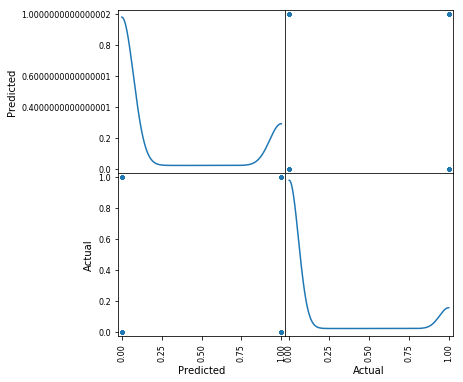

In [13]:
#Scatter Plot on the predicted labels from Decision Tree algorithm
%matplotlib inline
plot_df = labelsAndPredictions1.toDF()
plot_df_rename = plot_df.withColumnRenamed("_1", "Predicted").withColumnRenamed("_2", "Actual")
plot_pd = plot_df_rename.toPandas()

from pandas.tools.plotting import scatter_matrix
stuff = scatter_matrix(plot_pd, alpha=0.7, figsize=(6, 6), diagonal='kde')

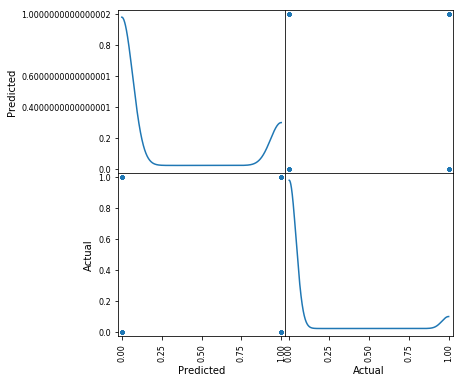

In [105]:
#Scatter Plot on the predicted labels from Random Forest algorithm
%matplotlib inline
plot_df = labelsAndPredictions2.toDF()
plot_df_rename = plot_df.withColumnRenamed("_1", "Predicted").withColumnRenamed("_2", "Actual")
plot_pd = plot_df_rename.toPandas()

from pandas.tools.plotting import scatter_matrix
stuff = scatter_matrix(plot_pd, alpha=0.7, figsize=(6, 6), diagonal='kde')

In [24]:
#ROC area and Precision Recall area for the Decision Tree algorithm results
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(labelsAndPredictions1)
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under PR = 0.34142117334274175
Area under ROC = 0.764231204070096


In [123]:
#ROC area and Precision Recall area for the RandomForest algorithm results
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(labelsAndPredictions2)
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under PR = 0.20560906531307463
Area under ROC = 0.7509265515293039


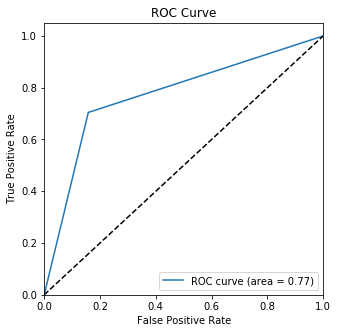

In [18]:
#ROC curve for the Decision Tree algorithm results
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline
plot_df = labelsAndPredictions2.toDF()
plot_df_rename = plot_df.withColumnRenamed("_1", "Predicted").withColumnRenamed("_2", "Actual")
plot_pd = plot_df_rename.toPandas()
# MAKE PREDICTIONS
#predictions_pddf = test_predictions.rename(columns={'_1': 'probability', '_2': 'label'})
#prob = predictions_pddf["probability"] 
fpr, tpr, thresholds = roc_curve(plot_pd['Actual'], plot_pd['Predicted'], pos_label=1);
roc_auc = auc(fpr, tpr)

# PLOT ROC CURVE
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

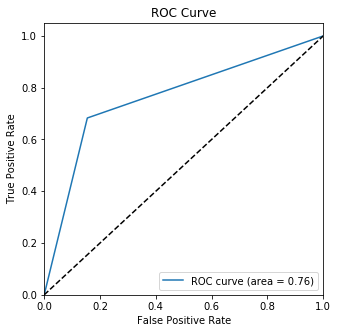

In [21]:
#ROC curve for the RandomForest algorithm results
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline
plot_df = labelsAndPredictions1.toDF()
plot_df_rename = plot_df.withColumnRenamed("_1", "Predicted").withColumnRenamed("_2", "Actual")
plot_pd = plot_df_rename.toPandas()
# MAKE PREDICTIONS
#predictions_pddf = test_predictions.rename(columns={'_1': 'probability', '_2': 'label'})
#prob = predictions_pddf["probability"] 
fpr, tpr, thresholds = roc_curve(plot_pd['Actual'], plot_pd['Predicted'], pos_label=1);
roc_auc = auc(fpr, tpr)

# PLOT ROC CURVE
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

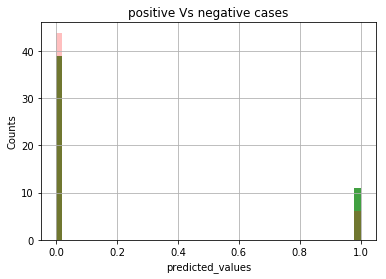

In [22]:
#plot the positive cases vs negative cases in Predicted and Actual
all_preds = plot_df_rename.select("Predicted").collect()
preds = [i[0] for i in all_preds]

all_act = plot_df_rename.select("Actual").collect()
actuals = [i[0] for i in all_act]

from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(preds, 50, normed=1, facecolor='green', alpha=1.75)
plt.hist(actuals, 50, normed=1, facecolor='red', alpha=0.25)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('positive Vs negative cases')
plt.grid(True)
plt.show()